# Deep Neural Network

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import copy
import torch.nn.functional as F

In [2]:
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu') # For Apple M1 Chip
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # For cuda

In [3]:
device

device(type='cpu')

## Hyperparameters

In [4]:
input_size = 28*28
hidden_size = 100
num_classes = 10 # 0 to 9 digits
num_epochs = 50
batch_size = 128 # Preferred to be a power of 2
learning_rate = 0.001

MNIST

In [5]:
train_dataset = torchvision.datasets.MNIST(
    root = '../datasets', 
    train = True, 
    transform = transforms.ToTensor(), 
    download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = '../datasets', 
    train = False, 
    transform = transforms.ToTensor(), 
    download = True
)

In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [8]:
examples = iter(train_loader)
inputs, labels = examples.next()
print(inputs, labels)
print('Input and Labels shape:', inputs.shape, labels.shape) # 28, 28 is the image size, 1 is for one colour channel (Not RGB but grayscale)
print('Unique Labels:', labels.unique())                     # 128 is the label & batch size as each label is assigned a different value from 0 to 9

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

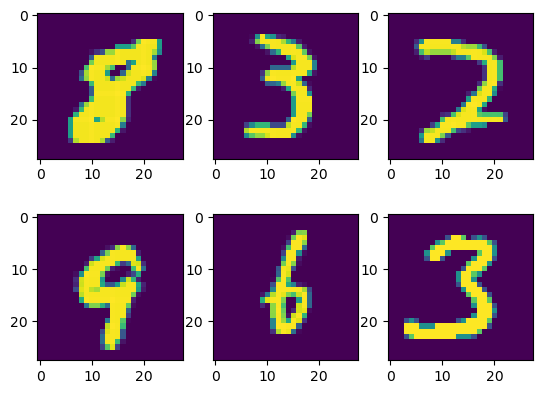

In [9]:
# For displaying the dataset MNIST
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(inputs[i][0]) # 6 from batch-size of 128

## Neural Network Model

In [10]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        # No softmax function here as it is already applied in the CrossEntropyLoss class in torch.nn

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return(out)

In [11]:
class NeuralNet2(nn.Module):
    def __init__(self, input_size = 2, hidden = [], num_classes=1, activations = [], seed=0):
        super().__init__()
        torch.manual_seed(seed)
        self.flatten = nn.Flatten()
        self.linear_stack = []
        if(len(hidden) != len(activations)-1):
            raise IndexError("Lengths passed for hidden and activations are not right")
        if(len(hidden) == 0):
            self.linear_stack.append(nn.Linear(input_size,num_classes))
            if(activations[0] == 'sigmoid'):
                self.linear_stack.append(nn.Sigmoid())
            elif(activations[0] == 'relu'):
                self.linear_stack.append(nn.ReLU())
            elif(activations[0] == 'tanh'):
                self.linear_stack.append(nn.Tanh())
            elif(activations[0] == 'softplus'):
                self.linear_stack.append(nn.Softplus())
        else:
            self.linear_stack.append(nn.Linear(input_size,hidden[0]))
            if(activations[0] == 'sigmoid'):
                self.linear_stack.append(nn.Sigmoid())
            elif(activations[0] == 'relu'):
                self.linear_stack.append(nn.ReLU())
            elif(activations[0] == 'tanh'):
                self.linear_stack.append(nn.Tanh())
            elif(activations[0] == 'softplus'):
                self.linear_stack.append(nn.Softplus())

            for i in range(len(hidden)-1):
                self.linear_stack.append(nn.Linear(hidden[i],hidden[i+1]))
                if(activations[i+1] == 'sigmoid'):
                    self.linear_stack.append(nn.Sigmoid())
                elif(activations[i+1] == 'relu'):
                    self.linear_stack.append(nn.ReLU())
                elif(activations[i+1] == 'tanh'):
                    self.linear_stack.append(nn.Tanh())
                elif(activations[i+1] == 'softplus'):
                    self.linear_stack.append(nn.Softplus())
            
            self.linear_stack.append(nn.Linear(hidden[-1],num_classes))
            if(activations[-1] == 'sigmoid'):
                self.linear_stack.append(nn.Sigmoid())
            elif(activations[-1] == 'relu'):
                self.linear_stack.append(nn.ReLU())
            elif(activations[-1] == 'tanh'):
                self.linear_stack.append(nn.Tanh())
            elif(activations[-1] == 'softplus'):
                self.linear_stack.append(nn.Softplus())
        self.neural_net = nn.Sequential(*self.linear_stack)
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.neural_net(x)
        return logits 

In [12]:
model1 = NeuralNet(input_size, hidden_size, num_classes).to(device)
model2 = NeuralNet2(input_size = input_size, hidden = [100, 80, 50], num_classes = num_classes, activations = ['relu', 'tanh', 'tanh', None]).to(device)

In [13]:
def MSELoss(y_hat, y_true):
    return torch.sum((y_hat - F.one_hot(y_true))**2)/len(y_hat)

In [14]:
# criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-5)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-5)

### Training model 1

In [15]:
torch.manual_seed(10)

In [16]:
summary(copy.deepcopy(model1).to('cpu'), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]          78,500
              ReLU-2                  [-1, 100]               0
            Linear-3                   [-1, 10]           1,010
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [17]:
summary(copy.deepcopy(model2).to('cpu'), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 80]           8,080
              Tanh-5                   [-1, 80]               0
            Linear-6                   [-1, 50]           4,050
              Tanh-7                   [-1, 50]               0
            Linear-8                   [-1, 10]             510
Total params: 91,140
Trainable params: 91,140
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.35
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [18]:
import time
tic = time.time()
n_steps = len(train_loader) # Total size//batch_size
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device) # From 128, 1, 28, 28 ---> 128, 784
        labels = labels.to(device)

        # forward pass
        pred_outputs = model1(images)
        # loss = criterion(pred_outputs, labels)
        loss = MSELoss(pred_outputs, labels)

        # back prop
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()

        if((i+1)%100 ==0):
            print(f'Epoch {epoch+1}/{num_epochs}; Step {i+1}/{n_steps}; Loss = {loss.item():.4f}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 1/50; Step 100/469; Loss = 0.9408
Epoch 1/50; Step 200/469; Loss = 0.8401
Epoch 1/50; Step 300/469; Loss = 0.7690
Epoch 1/50; Step 400/469; Loss = 0.7398
Epoch 2/50; Step 100/469; Loss = 0.6358
Epoch 2/50; Step 200/469; Loss = 0.5775
Epoch 2/50; Step 300/469; Loss = 0.5654
Epoch 2/50; Step 400/469; Loss = 0.5306
Epoch 3/50; Step 100/469; Loss = 0.5140
Epoch 3/50; Step 200/469; Loss = 0.4907
Epoch 3/50; Step 300/469; Loss = 0.4560
Epoch 3/50; Step 400/469; Loss = 0.4660
Epoch 4/50; Step 100/469; Loss = 0.4611
Epoch 4/50; Step 200/469; Loss = 0.3912
Epoch 4/50; Step 300/469; Loss = 0.4397
Epoch 4/50; Step 400/469; Loss = 0.4267
Epoch 5/50; Step 100/469; Loss = 0.3849
Epoch 5/50; Step 200/469; Loss = 0.3643
Epoch 5/50; Step 300/469; Loss = 0.3899
Epoch 5/50; Step 400/469; Loss = 0.3603
Epoch 6/50; Step 100/469; Loss = 0.4126
Epoch 6/50; Step 200/469; Loss = 0.4041
Epoch 6/50; Step 300/469; Loss = 0.3869
Epoch 6/50; Step 400/469; Loss = 0.3948
Epoch 7/50; Step 100/469; Loss = 0.3485


### Training model 2

In [21]:
tic = time.time()
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, input_size).to(device) # From 128, 1, 28, 28 ---> 128, 784
        labels = labels.to(device)

        # forward pass
        pred_outputs = model2(images)
        loss = MSELoss(pred_outputs, labels)

        # back prop
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()

        if((i+1)%100 ==0):
            print(f'Epoch {epoch+1}/{num_epochs}; Step {i+1}/{n_steps}; Loss = {loss.item():.4f}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 1/50; Step 100/469; Loss = 1.0539
Epoch 1/50; Step 200/469; Loss = 0.9547
Epoch 1/50; Step 300/469; Loss = 0.8538
Epoch 1/50; Step 400/469; Loss = 0.8140
Epoch 2/50; Step 100/469; Loss = 0.7468
Epoch 2/50; Step 200/469; Loss = 0.7249
Epoch 2/50; Step 300/469; Loss = 0.6716
Epoch 2/50; Step 400/469; Loss = 0.6573
Epoch 3/50; Step 100/469; Loss = 0.6001
Epoch 3/50; Step 200/469; Loss = 0.5620
Epoch 3/50; Step 300/469; Loss = 0.5803
Epoch 3/50; Step 400/469; Loss = 0.5735
Epoch 4/50; Step 100/469; Loss = 0.4995
Epoch 4/50; Step 200/469; Loss = 0.4983
Epoch 4/50; Step 300/469; Loss = 0.4750
Epoch 4/50; Step 400/469; Loss = 0.5085
Epoch 5/50; Step 100/469; Loss = 0.4782
Epoch 5/50; Step 200/469; Loss = 0.4454
Epoch 5/50; Step 300/469; Loss = 0.4014
Epoch 5/50; Step 400/469; Loss = 0.3964
Epoch 6/50; Step 100/469; Loss = 0.4103
Epoch 6/50; Step 200/469; Loss = 0.3737
Epoch 6/50; Step 300/469; Loss = 0.3552
Epoch 6/50; Step 400/469; Loss = 0.3637
Epoch 7/50; Step 100/469; Loss = 0.3458


In [22]:
# testing
with torch.no_grad():
    n_samples = 0
    n_correct1 = 0
    n_correct2 = 0
    for images, labels in test_loader:
        images = images.reshape(-1, input_size).to(device) # From 128, 1, 28, 28 ---> 128, 784
        labels = labels.to(device)
        pred_outputs1 = model1(images)
        pred_outputs2 = model2(images)
        _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
        _, actual_preds2 = torch.max(pred_outputs2, 1) # Returns value, index
        n_samples += labels.shape[0]
        n_correct1 += (actual_preds1 == labels).sum().item()
        n_correct2 += (actual_preds2 == labels).sum().item()

In [23]:
accuracy1 = n_correct1/n_samples * 100
accuracy2 = n_correct2/n_samples * 100
print(f'Accuracy for model = {accuracy1:.2f}%')
print(f'Accuracy for deeper model = {accuracy2:.2f}%')

Accuracy for model = 95.19%
Accuracy for deeper model = 95.27%


In [24]:
# train data testing
with torch.no_grad():
    n_samples = 0
    n_correct1 = 0
    n_correct2 = 0
    for images, labels in train_loader:
        images = images.reshape(-1, input_size).to(device) # From 128, 1, 28, 28 ---> 128, 784
        labels = labels.to(device)
        pred_outputs1 = model1(images)
        pred_outputs2 = model2(images)
        _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
        _, actual_preds2 = torch.max(pred_outputs2, 1) # Returns value, index
        n_samples += labels.shape[0]
        n_correct1 += (actual_preds1 == labels).sum().item()
        n_correct2 += (actual_preds2 == labels).sum().item()

In [25]:
accuracy1 = n_correct1/n_samples * 100
accuracy2 = n_correct2/n_samples * 100
print(f'Accuracy for model = {accuracy1:.2f}%')
print(f'Accuracy for deeper model = {accuracy2:.2f}%')

Accuracy for model = 95.19%
Accuracy for deeper model = 95.19%


# Testing with Random Forests

In [25]:
train_loader2 = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = len(train_loader)* batch_size,
    shuffle = True
)
test_loader2 = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = len(train_loader)* batch_size,
    shuffle = False
)

In [26]:
from sklearn.ensemble import RandomForestClassifier
for i, (images, labels) in enumerate(train_loader2):
    images = images.reshape(-1, input_size).detach().numpy() # From 128, 1, 28, 28 ---> 128, 784
    labels = labels.detach().numpy()
    rf = RandomForestClassifier(
        n_estimators=2000,
        n_jobs=32
    )
    rf.fit(images,labels)

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
for images, labels in test_loader2:
    images = images.reshape(-1, input_size).detach().numpy() # From 128, 1, 28, 28 ---> 128, 784
    labels = labels.detach().numpy()
    pred = rf.predict(images)
    cm = confusion_matrix(labels, pred)
    print(cm)
    print(f'Accuracy = {accuracy_score(labels, pred)*100}%')

[[ 969    0    0    0    0    3    3    1    3    1]
 [   0 1123    3    3    0    2    2    0    1    1]
 [   6    0 1000    6    2    0    4    8    6    0]
 [   0    0   11  973    0    6    0    9    8    3]
 [   1    0    1    0  957    0    5    0    2   16]
 [   3    0    0   10    3  862    6    1    5    2]
 [   7    3    0    0    2    3  940    0    3    0]
 [   1    2   17    1    1    0    0  993    1   12]
 [   4    0    6    7    4    5    3    3  931   11]
 [   5    5    2   10   13    3    1    5    5  960]]
Accuracy = 97.08%


## XGBoost method

In [28]:
import xgboost as xgb
for i, (images, labels) in enumerate(train_loader2):
    images = images.reshape(-1, input_size).detach().numpy() # From 128, 1, 28, 28 ---> 128, 784
    labels = labels.detach().numpy()
    xgboost1 = xgb.XGBClassifier(
        nthread = 8,
    )
    xgboost1.fit(images,labels)

In [29]:
for images, labels in test_loader2:
    images = images.reshape(-1, input_size).detach().numpy() # From 128, 1, 28, 28 ---> 128, 784
    labels = labels.detach().numpy()
    pred = xgboost1.predict(images)
    cm = confusion_matrix(labels, pred)
    print(cm)
    print(f'Accuracy = {accuracy_score(labels, pred)*100}%')

[[ 969    1    0    0    0    3    4    1    2    0]
 [   1 1124    2    3    0    1    3    1    0    0]
 [   5    0 1006    9    1    0    0    5    5    1]
 [   0    0    2  992    0    3    0    6    4    3]
 [   0    0    3    0  957    0    4    1    2   15]
 [   2    0    1    5    0  869    6    3    4    2]
 [   7    3    0    0    2    3  939    0    4    0]
 [   1    1   14    3    2    0    0  998    2    7]
 [   4    1    3    2    3    3    2    2  948    6]
 [   6    5    1    5    7    1    0    3    3  978]]
Accuracy = 97.8%
